# This notebook is for testing work with PointingGroups

In [11]:
import pointings

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [12]:
# load pointings
pg = pointings.PointingGroups.load("test")

In [13]:
def plot_pointings(visit_id, ra, dec):
    arcsec2degree = 0.000277778
    pixscale = 0.2637 #arcsec/px
    
    height   = 2048 * pixscale * arcsec2degree
    width    = 4096 * pixscale * arcsec2degree
    angle    = [0]*len(ra)

    fig, ax = plt.subplots(figsize=(13, 9))

    rect_patches = []
    for i, r, d, a in zip(visit_id, ra, dec, angle):
        # this will likely kill the notebook
        #annot = ax.text(r-0.001, d-0.001, i, fontsize=12)
        #                 lower left corner        height  width  angle
        rect = Rectangle((r-height/2., d-width/2.), height, width, a)
        rect_patches.append(rect)
    rect_patches_collection = PatchCollection(rect_patches, alpha=0.1)
    ax.add_collection(rect_patches_collection)

    ax.scatter(ra, dec, color="red")

<IPython.core.display.Javascript object>


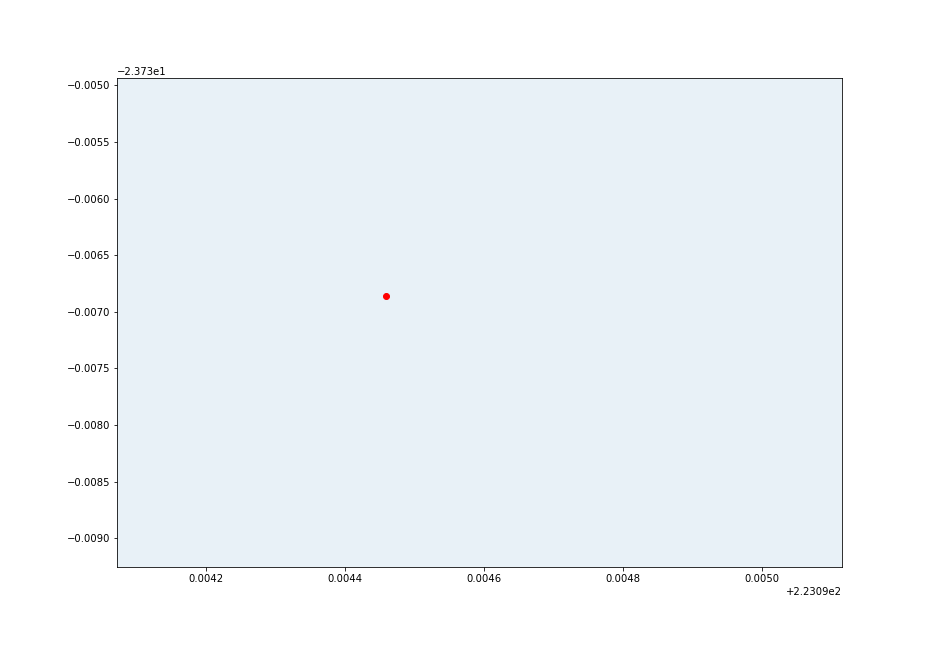

In [14]:
# make a plot of all pointings 
visit_id = pg.table["visit_id"]
ra       = pg.table["ra"]
dec      = pg.table["dec"]
plot_pointings(visit_id, ra, dec)

<IPython.core.display.Javascript object>


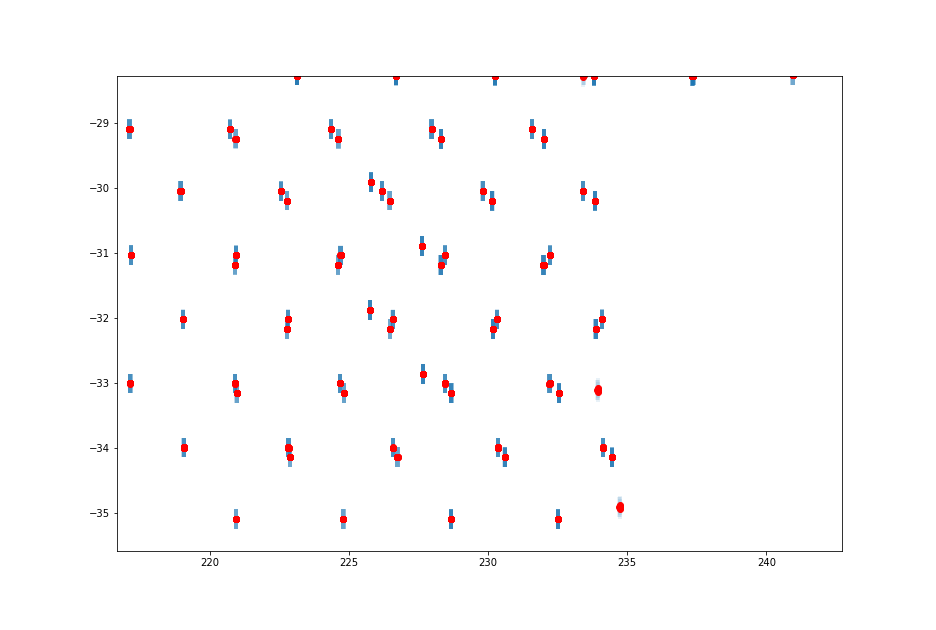

In [15]:
# recreate that plot for grouped pointings only (shouldn't be a lot of difference)
visit_id = pg["visit_id"]
ra       = pg["ra"]
dec      = pg["dec"]
plot_pointings(visit_id, ra, dec)

In [146]:
# Pairs are created from grouped pointings by iterating through all the pointings in a group and calculating the
# time difference dt between two exposures. The pair that has the largest dt will be image differenced. 
# For testing purposes we start from the pointing ra, dec = (207.354958, -7.519750). 
foi = sorted_fields[4]
maxdt = time.TimeDelta(0, format="sec")
pairs = []

for science in foi.iterrows():
    sci_id, sci_date, sci_ra, sci_dec, sci_filename, sci_night = science[1]
    sci_date = time.Time(sci_date.decode("utf-8"))
    
    for template in foi.iterrows(): 
        tmplt_id, tmplt_date, tmplt_ra, tmplt_dec, tmplt_filename, tmplt_night = template[1]
        tmplt_date = time.Time(tmplt_date.decode("utf-8"))
        
        # dt is a astropy.time.TimeDelta object and can not be compared to non TimeDelta objects
        # it recognizes positive and negative time delta so we check for its absolute value
        dt = sci_date - tmplt_date     
        if abs(dt) > time.TimeDelta(maxdt):
            maxdt = dt
            if science[1]["visit_id"] != template[1]["visit_id"]:
                pair = (science[1], template[1], abs(dt))               
    
    pairs.append(pair)
    maxdt = time.TimeDelta(0, format="sec")

In [153]:
# check if all pairs make sense, third columns is the dt in hours
for pair in pairs:
    print(pair[0]["visit_id"], pair[1]["visit_id"], pair[2].sec/60./60.)

303582 306264 95.96688805555556
303586 306264 95.88965944444445
303590 306264 95.81338055555555
303594 306264 95.73621444444444
303598 306264 95.65812722222223
304273 306264 71.48849416666667
304277 306264 71.41079166666667
304281 306264 71.3330913888889
304285 306264 71.25496972222224
304289 306264 71.17744027777778
304919 303582 48.45832166666666
304923 303582 48.536081111111116
304927 303582 48.61380888888889
304931 303582 48.69164666666667
304935 303582 48.769412499999994
305566 303582 71.69231888888889
305570 303582 71.76818555555556
305574 303582 71.84395388888889
305578 303582 71.92095
305582 303582 71.99711305555556
306248 303582 95.65773555555555
306252 303582 95.7346563888889
306256 303582 95.81085305555555
306260 303582 95.8888438888889
306264 303582 95.96688805555556


In [126]:
# Create the image differencing scripts in folder jobs

rerunpath = "/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/r207.354958d-7.519750/Processed_Data/rerun/singleFrameDriver_rerun"

ncpu = 20
outpath = "imdiff_r207.354958d-7.519750"
cfgfile = "config.py"
cmd = ("imageDifference.py {rerunpath} -j {ncpu} --output {outpath} -C {cfgfile} --longlog "+
       "--timeout 18000 --id visit={visitid} --templateId visit={templateid}\n")

with open("jobs/jobs_specialty.sh", "w") as f:
    for pair in pairs:
        f.write(cmd.format(rerunpath=rerunpath, ncpu=ncpu, outpath=outpath, cfgfile=cfgfile, 
                           visitid=int(pair[0]["visit_id"]), templateid=int(pair[1]["visit_id"])))